<a href="https://colab.research.google.com/github/StevenVuong/MSc_Project/blob/master/v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive

# mount google drive into google colab
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os

# go to where the data is
os.chdir('gdrive/My Drive/msc_project')
os.listdir()

['ppmi_scans', 'THIS_IS_IT.csv']

In [0]:
# standard imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pydicom

%matplotlib inline

**Exploring the Data**

In [0]:
# import data and show head
df = pd.read_csv('THIS_IS_IT.csv')
df.head()

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,377981,4139,Control,M,81,1,MRI,Axial PD-T2 TSE FS,Original,04/09/2013,DCM,NaN
1,436432,4136,PD,M,57,5,MRI,Axial PD-T2 TSE FS,Original,05/06/2014,DCM,NaN
2,377973,4136,PD,M,56,1,MRI,Axial PD-T2 TSE FS,Original,2/28/2013,DCM,NaN
3,377952,4135,PD,M,67,1,MRI,Axial PD-T2 TSE FS,Original,03/01/2013,DCM,NaN
4,377945,4085,Control,M,67,1,MRI,Axial PD-T2 TSE FS,Original,04/08/2013,DCM,NaN


In [0]:
descriptions_array = df.Description.values
np.unique(descriptions_array, return_counts=True) # shows what the data looks like, we can take the FS (Fast Spin) exemplars

(array(['AXIAL PD-T2 TSE FS', 'Axial PD-T2 TSE', 'Axial PD-T2 TSE FS',
        'Axial PD-T2 TSE_AC PC line', 'Axial PD-T2 TSE_AC/PC line',
        'Axial PD-T2-FS TSE', 'T2'], dtype=object),
 array([ 33, 292, 356,   2,  24,  23,   1]))

So we can see that the majority is Axial PD-T2 TSE and Axial PD-T2 TSE FS, leaving us with 292 or 356. 

In [0]:
# looks like a bunch of Axial PD-T2 TSE are mislabelled or slightly different, change these
dscrptn = df['Description'].replace({'Axial PD-T2-FS TSE':'Axial PD-T2 TSE FS', 'AXIAL PD-T2 TSE FS':'Axial PD-T2 TSE FS', 
                           'Axial PD-T2 TSE_AC PC line':'Axial PD-T2 TSE_AC/PC line'})

df['Description'] = dscrptn

In [0]:
np.unique(df.Description.values, return_counts=True) 

(array(['Axial PD-T2 TSE', 'Axial PD-T2 TSE FS',
        'Axial PD-T2 TSE_AC/PC line', 'T2'], dtype=object),
 array([292, 412,  26,   1]))

Looks about right, decide to go with TSE FS as this has more data. Looks like many patients had both scans.

In [0]:
df2 = df[df['Description']=='Axial PD-T2 TSE FS']
print (len(df2))
df2.head()

412


,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,377981,4139,Control,M,81,1,MRI,Axial PD-T2 TSE FS,Original,04/09/2013,DCM,NaN
1,436432,4136,PD,M,57,5,MRI,Axial PD-T2 TSE FS,Original,05/06/2014,DCM,NaN
2,377973,4136,PD,M,56,1,MRI,Axial PD-T2 TSE FS,Original,2/28/2013,DCM,NaN
3,377952,4135,PD,M,67,1,MRI,Axial PD-T2 TSE FS,Original,03/01/2013,DCM,NaN
4,377945,4085,Control,M,67,1,MRI,Axial PD-T2 TSE FS,Original,04/08/2013,DCM,NaN


In [0]:
# Change the object type to dates for date
df2['Acq Date'] = pd.to_datetime(df2['Acq Date'], format='%d/%M/%Y')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
df2.info() # just get understanding of types of data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412 entries, 0 to 729
Data columns (total 12 columns):
Image Data ID    412 non-null int64
Subject          412 non-null int64
Group            412 non-null object
Sex              412 non-null object
Age              412 non-null int64
Visit            412 non-null int64
Modality         412 non-null object
Description      412 non-null object
Type             412 non-null object
Acq Date         412 non-null datetime64[ns]
Format           412 non-null object
Downloaded       0 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(6)
memory usage: 41.8+ KB


In [0]:
# count number with PD and number of controls
np.unique(df2.Group, return_counts=True)

(array(['Control', 'PD'], dtype=object), array([ 50, 362]))

In [0]:
# So keep only one scan per patient and use the most recent scans
df3 = df2.sort_values('Acq Date').drop_duplicates('Subject',keep='last')

In [0]:
# count number with PD and number of controls
np.unique(df3.Group, return_counts=True)

(array(['Control', 'PD'], dtype=object), array([ 36, 154]))

We can see that some patients have multiple scans and different dates. Treat these as independent occurances. 
<br>
Plan:
-  Get all subject ID's
-  Search these folders, if more than 1 subfolder, take the second which will be the TSE FS files
-  Then each scan subfolder is treated as an independent case (important to mention) as we have 412 patients but 729 scans i.e. some patients had more than one scan over time. Balance this out by just selecting one image per patient
    -  By one image per patient, it is meant that the last image is selected for classification, so we should have 412 images overall, balancing out the ratio slightly. Select the last one
    -  Problem with selecting the last one however is that it is the latest scan (most recent one), meaning it is more likely to be later stage PD in development. Meaning we may have a harder time diagnosing those with early stages of PD
    -  Way to go around this would be to train with the earliest stage of a classifier or use another MRI data source set

In [0]:
# establish control and pd df's
df_control = df2[df2.Group == 'Control'] # for control, keep duplicate subject n.o's
df_pd = df3[df3.Group == 'PD'] 

In [0]:
print ("Number of control patients: %d " % len(df_control))
print ("Number of PD patients: %d " % len(df_pd))

Number of control patients: 50 
Number of PD patients: 154 


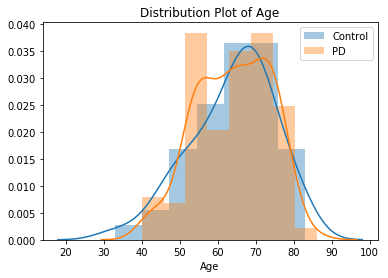

In [0]:
# seaborn distribution plot
sns.distplot(df_control.Age, rug=False, label='Control')
sns.distplot(df_pd.Age, rug=False, label='PD')
plt.title('Distribution Plot of Age')
plt.legend()
plt.show()

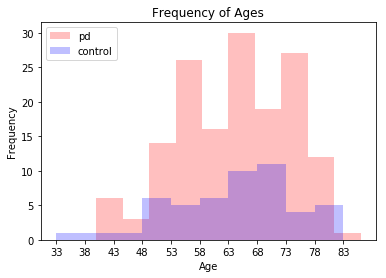

In [0]:
# plot for the ages
plt.hist(df_pd.Age, align='mid', alpha=0.25, color='r', label='pd', bins=10)
plt.hist(df_control.Age, align='mid', alpha=0.25, color='b', label='control', bins=10)
plt.legend(loc='upper left')

# set labels
plt.ylabel('Frequency')
plt.xlabel('Age')
plt.title('Frequency of Ages')

# set ticks
plt.xticks(np.arange(min(df_control.Age), max(df_control.Age)+1, 5.0))
plt.show()

What can happen if we have too many PD compared to control? Without balancing (by only allowing one scan per patient, we reduce the ratio from 7:1 between PD to Control to about 1:5. If we just do this method for PD patients only, we can set the ratio to about 1:3 (which is what we will go with) so we have a balanced set to train as possible. Though it means we only have 204 instances to train with.

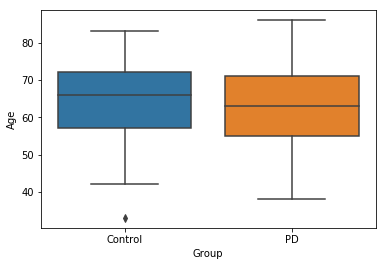

In [0]:
# some boxplots
ax = sns.boxplot(x="Group", y="Age", data=df2)

For each, control and PD we can state the number of M and F in each.

In [0]:
print ("For Control:")
print (np.unique(df_control.Sex.values, return_counts=True))
print ("For PD")
print (np.unique(df_pd.Sex.values, return_counts=True))

For Control:
(array(['F', 'M'], dtype=object), array([10, 40]))
For PD
(array(['F', 'M'], dtype=object), array([ 53, 101]))


##### Find the right subjects and image scan ID's and search files for these, build a list of directories to scan
Then build a corresponding datastructure.
-  Datastructure: Dictionary {Image_ID: List of DCM Files}

In [0]:
# Logic:
# First compile both control and PD into some super DF
# Then make a list of all the corresponding subject ID's
# Then make a list of all the corresponding Image ID's

# Loop through to get the right folders (one that match with subject ID)
# open the last subfolder (MRI TSE) *So using [-1] slicing*
# open the last subfolder again ( most recent dated image )
# 's' + image_id is the subfolder to store
# store the path

# Then Store the list of DCM files 

In [0]:
df_u = pd.concat([df_control, df_pd]) # df ultima
df_u = df_u.sample(frac=1) # randomly shuffle df
df_u.head()

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
108,415752,3870,PD,F,43,5,MRI,Axial PD-T2 TSE FS,Original,2014-01-01 00:15:00,DCM,NaN
124,395288,3857,Control,F,42,5,MRI,Axial PD-T2 TSE FS,Original,2012-01-10 00:19:00,DCM,NaN
470,369478,3368,Control,F,55,5,MRI,Axial PD-T2 TSE FS,Original,2013-01-01 00:31:00,DCM,NaN
702,393644,3113,PD,F,61,7,MRI,Axial PD-T2 TSE FS,Original,2013-01-07 00:17:00,DCM,NaN
651,482301,3131,PD,M,73,7,MRI,Axial PD-T2 TSE FS,Original,2015-01-03 00:11:00,DCM,NaN


In [0]:
u_subject_id = df_u.Subject.values # gets the required ID's
u_subject_id

array([3870, 3857, 3368, 3113, 3131, 3390, 3378, 3592, 3350, 3831, 3301,
       3852, 3763, 3588, 3353, 3787, 3863, 4069, 3185, 3551, 3780, 3181,
       4030, 3589, 4032, 3134, 3802, 3367, 3321, 3325, 3124, 4038, 3575,
       3808, 3838, 3563, 4027, 3552, 4022, 3308, 3853, 3853, 3571, 4026,
       3557, 3383, 4011, 3361, 3127, 3364, 3354, 3389, 3221, 4018, 3830,
       3752, 3593, 3184, 3605, 4029, 4037, 3357, 3868, 4021, 3123, 4139,
       3132, 3869, 3558, 3852, 3574, 4136, 3369, 3190, 3815, 3316, 4135,
       4067, 4085, 3332, 4035, 3825, 3125, 4081, 4019, 3591, 3834, 3359,
       3154, 3565, 3556, 3392, 3352, 3854, 3176, 3385, 3826, 3835, 3328,
       3129, 3102, 3390, 3122, 3559, 3824, 3174, 3775, 3179, 3175, 3832,
       4005, 3380, 3577, 3374, 3173, 3323, 3351, 4020, 3301, 3859, 3377,
       3781, 3762, 3814, 3106, 3310, 3178, 4012, 4001, 3758, 3105, 3818,
       3106, 3779, 3788, 3770, 3386, 3857, 3107, 3182, 3119, 3116, 3365,
       3372, 3309, 3108, 3327, 3769, 3318, 3822, 35

**Now actually go to file with all the scans**

In [0]:
os.chdir('ppmi_scans') # go to file with all the scans

In [0]:
subject_ids = os.listdir()
path = os.getcwd()

In [0]:
# vertical then horizontal, go into first subject id
path_p1 = (path + '/' + str(subject_ids[0])) # get first id
path_p2 = (path_p1 + '/' + os.listdir(path_p1)[-1]) # get fs
path_p3 = (path_p2 + '/' + os.listdir(path_p2)[-1]) # get most recent scan
path_p4 = (path_p3 + '/' + os.listdir(path_p3)[-1]) # p_4 has all the dcm files

os.listdir(path_p4)[:5] # the part beginning 'I482301' is the part which is the image ID

['PPMI_3308_MR_Axial_PD-T2_TSE_AC_PC_line_br_raw_20130430112447588_89_S188385_I369377.dcm',
 'PPMI_3308_MR_Axial_PD-T2_TSE_AC_PC_line_br_raw_20130430112446480_57_S188385_I369377.dcm',
 'PPMI_3308_MR_Axial_PD-T2_TSE_AC_PC_line_br_raw_20130430112446527_60_S188385_I369377.dcm',
 'PPMI_3308_MR_Axial_PD-T2_TSE_AC_PC_line_br_raw_20130430112447088_80_S188385_I369377.dcm',
 'PPMI_3308_MR_Axial_PD-T2_TSE_AC_PC_line_br_raw_20130430112447276_86_S188385_I369377.dcm']

In [0]:
print (path_p4)

/content/gdrive/My Drive/msc_project/ppmi_scans/3308/Axial_PD-T2_TSE_AC_PC_line/2013-01-17_11_07_46.0/S188385


In [0]:
dcm_files_test = os.listdir(path_p4) # get an individual dcom file
length_of_dcm = (len(dcm_files_test)) # get range length
print (length_of_dcm)

48


In [0]:
os.chdir(path_p4) # change the working dir to path p4
os.getcwd()

'/content/gdrive/My Drive/msc_project/ppmi_scans/3308/Axial_PD-T2_TSE_AC_PC_line/2013-01-17_11_07_46.0/S188385'

In [0]:
dcm_files_test[0]

'PPMI_3308_MR_Axial_PD-T2_TSE_AC_PC_line_br_raw_20130430112447588_89_S188385_I369377.dcm'

In [0]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [0]:
# make it a function for a widget
def f(i):
    slices = pydicom.read_file(dcm_files_test[i]) # uh oh, it is not ordered
    plt.imshow(slices.pixel_array)
    plt.show()
    return None

In [0]:
interact(f, i=14) # now we have a slidebar, woo! Covers all data values

interactive(children=(IntSlider(value=14, description='i', max=42, min=-14), Output()), _dom_classes=('widget-…

<function __main__.f>

Problem: Need to order slices properly

In [0]:
def filename_sort(filename):
    int_return = None # what to return 
    
    if (len(filename) == 79):
        int_return = int(filename[57:59]) # if 2 characters
    if (len(filename) == 80):
        int_return = int(filename[57:60]) # if 3 characters
    if (len(filename) == 78):
        int_return = int(filename[57]) # if 1 character
        
    return int_return

Note: The 3 characer approach might not work for 1 character

In [0]:
sorted_slices = sorted(dcm_files_test, key=lambda filename: filename_sort(filename)) # some have length 3
sorted_slices[:5] # perfect

TypeError: ignored

In [0]:
# make it a function for a widget
def f(i):
    slices = pydicom.read_file(sorted_slices[i]) # uh oh, it is not ordered
    plt.imshow(slices.pixel_array)
    plt.show()
    return None

In [0]:
interact(f, i=widgets.IntSlider(min=0,max=(len(sorted_slices)-1),step=1,value=0)) # now we have a sorted slidebar!, wooooo! Covers all data values

In [0]:
# turn the slices array into a matrix for input into our deep learning model
pixel_arrays = [(pydicom.read_file(s)).pixel_array for s in sorted_slices]
pixel_arrays = np.array(pixel_arrays)

print ("3D Pixel Arrays: %s" % (np.shape(pixel_arrays),))

The above is then an example of obtaining one pixel array for one set of scans, we will then attach that to a key which has image_id. This will allow us to cross reference this to whether the patient has PD or not.

#### Now try to skull strip and segment the brain tissue, we can use the example of pixel_arrays (Method 1 mask)

In [0]:
import nibabel as nb # write/process to some common neuroimaging file formats
from deepbrain import Extractor # Trying now, installing a bunch of packages..

Found the problem space, will try to see if this works with deepbrain. Seems like problem is converting the image type

Made test file with nii file (after conversion with dicom2nifti #https://github.com/icometrix/dicom2nifti then using that and converting it. Then made another folder and dumped the files in there. (Perhaps should dump all into one common folder though. Also there is a good possibility that we lose the order of our images. So may need to re-order these in the file after sorting. Or apply the mask THEN re-order the files!

In [0]:
import dicom2nifti

# Converting a directory with dicom files to nifti files
dicom_directory = os.getcwd()
output_folder = os.getcwd()[:-7] # put file in the folder superseding the most recent
dicom2nifti.convert_directory(dicom_directory, output_folder, compression=True, reorient=True)

In [0]:
os.chdir(output_folder)
os.listdir() # it is the first file on the list

In [0]:
newdir = os.getcwd() + '\\' +os.listdir()[0] # go to the new folder

In [0]:
pa = pixel_arrays.copy() # just make a copy of the pixel array and run with this. no need for nifti

In [0]:
# Load a nifti as 3d numpy image [H, W, D]
# img = nb.load(newdir).get_fdata() # loads it even as a gz file

ext = Extractor()

# `prob` will be a 3d numpy image containing probability 
# of being brain tissue for each of the voxels in `img`
prob = ext.run(pa) 

# mask can be obtained as:
mask = prob > 0 # may have to adjust this value, make a mask out of it

In [0]:
pa[mask] = 0 # apply the mask itself

In [0]:
def g(i): # basic slideshow plot to get an idea of the effectiveness of the mask itself
    plt.figure(figsize=(15,8)) # make plot larger
    plt.imshow(pa[i], cmap='gray') # made grayscale, just to compare this to
    plt.show()
    return None

In [0]:
interact(g, i=widgets.IntSlider(min=0,max=(54-1),step=1,value=0)) # now we have a sorted slidebar!, wooooo! Covers all data values

Mask works, but skull stripping doesn't seem to effective at all.. Rather shite, Mostly for T1: 
-  https://pypi.org/project/deepbrain/. Give up on this.

<br>
    Paper comparing methods for skull stripping: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4879034/

#### Now try another method (Method 2 mask)

In [0]:
# Let's create a short helper function to plot 3D NIfTI images
def plot_slice(fname):

    # Load the image
    img = nb.load(fname)
    data = img.get_data()

    # Cut in the middle of the brain
    cut = int(data.shape[-1]/2) + 10

    # Plot the data
    plt.imshow(np.rot90(data[..., cut]), cmap="gray")
    plt.gca().set_axis_off()

In [0]:
from nipype.interfaces import fsl # try to skull strip with a simple procedural code

In [0]:
print (newdir)

In [0]:
# Skullstrip process
skullstrip = fsl.BET(
    in_file= newdir,
    out_file=os.getcwd(),
    mask=True)
skullstrip.run()